# Feature Selection on Simulated Data 

## a. Generate predictor and noise

In [2]:
import numpy as np

X, e = np.random.normal(size=100), np.random.normal(size=100)

In [3]:
X.shape

(100,)

## b. Generate response

In [2]:
(beta_0, beta_1, beta_2, beta_3) = 1, 1, 1, 1

y = beta_0*np.array(100*[1]) + beta_1*X + beta_2*X**2 + beta_2*X**3 + e

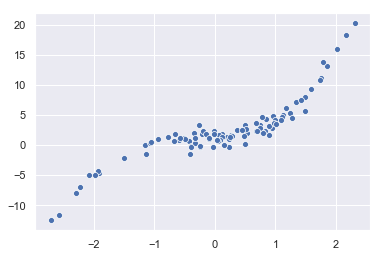

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

sns.scatterplot(x=X, y=y)

## c. Best Subset Selection

First we generate the predictors $X^2, \dots, X^{10}$ and assemble all data in a dataframe

In [4]:
import pandas as pd

data = pd.DataFrame({'X^' + str(i): X**i for i in range(11)})
data['y'] = y
data.head()

,X^0,X^1,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10,y
0,1.0,0.115404,0.013318,0.001537,0.000177,0.000020,0.000002,2.726196e-07,3.146150e-08,3.630796e-09,4.190099e-10,1.914734
1,1.0,-0.594583,0.353530,-0.210203,0.124983,-0.074313,0.044185,-2.627180e-02,1.562078e-02,-9.287856e-03,5.522406e-03,0.848536
2,1.0,1.751695,3.068436,5.374965,9.415301,16.492737,28.890250,5.060691e+01,8.864789e+01,1.552841e+02,2.720104e+02,11.091760
3,1.0,-0.662284,0.438620,-0.290491,0.192387,-0.127415,0.084385,-5.588676e-02,3.701289e-02,-2.451304e-02,1.623459e-02,1.893104
4,1.0,-1.921016,3.690302,-7.089130,13.618332,-26.161034,50.255764,-9.654213e+01,1.854590e+02,-3.562696e+02,6.843997e+02,-4.628707


The `mlxtend` library has [exhaustive feature selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/#api)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# dict for results
bss = {}

for k in range(1, 12):
    reg = LinearRegression()
    efs = EFS(reg, 
               min_features=k,
               max_features=k,
               scoring='neg_mean_squared_error',
               print_progress=False,
               cv=None)
    efs = efs.fit(data.drop(columns=['y']), data['y'])
    bss[k] = efs.best_idx_

bss

{1: (3,),
 2: (2, 3),
 3: (1, 2, 3),
 4: (1, 2, 3, 7),
 5: (1, 2, 3, 9, 10),
 6: (1, 2, 3, 6, 8, 9),
 7: (1, 2, 3, 6, 7, 9, 10),
 8: (1, 2, 3, 4, 6, 8, 9, 10),
 9: (1, 2, 4, 5, 6, 7, 8, 9, 10),
 10: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
 11: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)}

Now we'll calculate $AIC, BIC$ and adjusted $R^2$ for each subset size and plot (We'll use $AIC$ instead of $C_p$ since they're proportional).

First some helper functions for $AIC, BIC$ and adjusted $R^2$

In [6]:
from math import log

def AIC(n, rss, d, var_e):
    return (1 / (n * var_e)) * (rss + 2 * d * var_e)

def BIC(n, rss, d, var_e):
    return (1 / (n * var_e)) * (rss + log(n) * d * var_e)

def adj_r2(n, rss, tss, d):
    return 1 - ((rss / (n - d - 1)) / (tss / (n - 1)))

Then calculate

In [7]:
def mse_estimates(X, y, bss):
    n, results = X.shape[1], {}
    for k in bss:
        model_fit = LinearRegression().fit(X[:, bss[k]], y)
        y_pred = model_fit.predict(X[:, bss[k]])
        
        errors = y - y_pred
        rss = np.dot(errors, errors)
        var_e = np.var(errors)
        tss = np.dot((y - np.mean(y)), (y - np.mean(y)))
        
        results[k] = dict(AIC=AIC(n, rss, k, var_e), BIC=BIC(n, rss, k, var_e),
                          adj_r2=adj_r2(n, rss, rss, k))
    return results

In [8]:
X, y = data.drop(columns=['y']).values, data['y'].values
mses = mse_estimates(X, y, bss)
mses

/Users/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


{1: {'AIC': 9.272727272727272,
  'BIC': 9.308899570254397,
  'adj_r2': -0.11111111111111094},
 2: {'AIC': 9.454545454545455, 'BIC': 9.526890049599706, 'adj_r2': -0.25},
 3: {'AIC': 9.636363636363633,
  'BIC': 9.744880528945009,
  'adj_r2': -0.4285714285714284},
 4: {'AIC': 9.81818181818182,
  'BIC': 9.962871008290318,
  'adj_r2': -0.6666666666666665},
 5: {'AIC': 10.0, 'BIC': 10.180861487635624, 'adj_r2': -1.0},
 6: {'AIC': 10.181818181818185, 'BIC': 10.398851966980931, 'adj_r2': -1.5},
 7: {'AIC': 10.363636363636365,
  'BIC': 10.616842446326237,
  'adj_r2': -2.3333333333333335},
 8: {'AIC': 10.545454545454545, 'BIC': 10.834832925671542, 'adj_r2': -4.0},
 9: {'AIC': 10.727272727272727, 'BIC': 11.05282340501685, 'adj_r2': -9.0},
 10: {'AIC': 10.909090909090908, 'BIC': 11.270813884362154, 'adj_r2': -inf},
 11: {'AIC': 11.090909090909093, 'BIC': 11.488804363707464, 'adj_r2': 11.0}}

In [9]:
AICs = np.array([mses[k]['AIC'] for k in mses])
BICs = np.array([mses[k]['BIC'] for k in mses])
adj_r2s = np.array([mses[k]['adj_r2'] for k in mses])

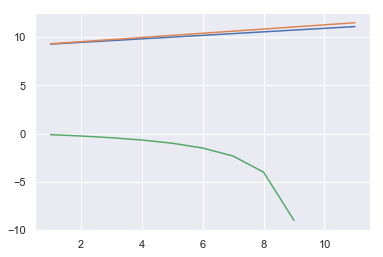

In [10]:
x = np.arange(1, 12)
sns.lineplot(x, AICs)
sns.lineplot(x, BICs)
sns.lineplot(x, adj_r2s)

The best model has the highest AIC/BIC and lowest adjusted $R^2$, so on this basis, the model with $X^3$ the only feature is the best. 

The coefficient is:

In [11]:
bss_model = LinearRegression().fit(X[:, 3].reshape(-1, 1), y)
bss_model.coef_

array([1.06262895])

Now, lets generate a validataion data set and check this model's mse

In [12]:
X_valid, e_valid = np.random.normal(size=100), np.random.normal(size=100)
(beta_0, beta_1, beta_2, beta_3) = 1, 1, 1, 1
y_valid = beta_0*np.array(100*[1]) + beta_1*X_valid + beta_2*X_valid**2 + beta_2*X_valid**3 + e

In [13]:
y_pred = bss_model.coef_ * X_valid**3
errors = y_pred - y_valid
bss_mse_test = np.mean(np.dot(errors, errors))
bss_mse_test

642.7014227682031

We'll save the results for later comparison

In [14]:
model_selection_df = pd.DataFrame({'mse_test': [bss_mse_test]}, index=['bss'])
model_selection_df

,mse_test
bss,642.701423


## d. Forward and Backward Stepwise Selection

`mlxtend` also has forward and backward stepwise selection

First we look at forward stepwise selection.

In [15]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

X, y = data.drop(columns=['y']).values, data['y'].values
# dict for results
fss = {}

for k in range(1, 12):
    sfs = SFS(LinearRegression(), 
          k_features=k, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error')
    sfs = sfs.fit(X, y)
    fss[k] = sfs.k_feature_idx_

fss

{1: (3,),
 2: (2, 3),
 3: (1, 2, 3),
 4: (1, 2, 3, 9),
 5: (0, 1, 2, 3, 9),
 6: (0, 1, 2, 3, 9, 10),
 7: (0, 1, 2, 3, 5, 9, 10),
 8: (0, 1, 2, 3, 4, 5, 9, 10),
 9: (0, 1, 2, 3, 4, 5, 7, 9, 10),
 10: (0, 1, 2, 3, 4, 5, 7, 8, 9, 10),
 11: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)}

In [16]:
mses = mse_estimates(X, y, fss)
mses

/Users/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


{1: {'AIC': 9.272727272727272,
  'BIC': 9.308899570254397,
  'adj_r2': -0.11111111111111094},
 2: {'AIC': 9.454545454545455, 'BIC': 9.526890049599706, 'adj_r2': -0.25},
 3: {'AIC': 9.636363636363633,
  'BIC': 9.744880528945009,
  'adj_r2': -0.4285714285714284},
 4: {'AIC': 9.818181818181818,
  'BIC': 9.962871008290316,
  'adj_r2': -0.6666666666666667},
 5: {'AIC': 10.0, 'BIC': 10.180861487635623, 'adj_r2': -1.0},
 6: {'AIC': 10.181818181818182, 'BIC': 10.39885196698093, 'adj_r2': -1.5},
 7: {'AIC': 10.363636363636365,
  'BIC': 10.616842446326237,
  'adj_r2': -2.3333333333333335},
 8: {'AIC': 10.545454545454547, 'BIC': 10.834832925671542, 'adj_r2': -4.0},
 9: {'AIC': 10.727272727272727, 'BIC': 11.052823405016847, 'adj_r2': -9.0},
 10: {'AIC': 10.90909090909091, 'BIC': 11.270813884362157, 'adj_r2': -inf},
 11: {'AIC': 11.090909090909093, 'BIC': 11.488804363707464, 'adj_r2': 11.0}}

In [17]:
AICs = np.array([mses[k]['AIC'] for k in mses])
BICs = np.array([mses[k]['BIC'] for k in mses])
adj_r2s = np.array([mses[k]['adj_r2'] for k in mses])

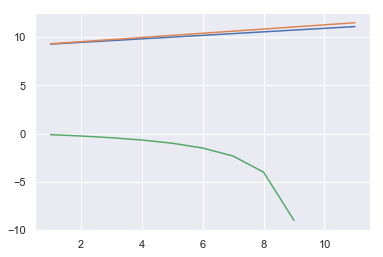

In [18]:
x = np.arange(1, 12)
sns.lineplot(x, AICs)
sns.lineplot(x, BICs)
sns.lineplot(x, adj_r2s)

FSS also selects the model with $X^3$ the only feature.

Now we consider backward stepwise selection.

In [19]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# dict for results
bkss = {}

for k in range(1, 12):
    sfs = SFS(LinearRegression(), 
          k_features=k, 
          forward=False, 
          floating=False, 
          scoring='neg_mean_squared_error')
    sfs = sfs.fit(X, y)
    bkss[k] = sfs.k_feature_idx_

bkss

{1: (3,),
 2: (2, 3),
 3: (1, 2, 3),
 4: (1, 2, 3, 9),
 5: (1, 2, 3, 8, 9),
 6: (1, 2, 3, 7, 8, 9),
 7: (1, 2, 3, 6, 7, 8, 9),
 8: (0, 1, 2, 3, 6, 7, 8, 9),
 9: (0, 1, 2, 3, 5, 6, 7, 8, 9),
 10: (0, 1, 2, 3, 5, 6, 7, 8, 9, 10),
 11: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)}

In [20]:
mses = mse_estimates(X, y, bkss)
mses

/Users/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


{1: {'AIC': 9.272727272727272,
  'BIC': 9.308899570254397,
  'adj_r2': -0.11111111111111094},
 2: {'AIC': 9.454545454545455, 'BIC': 9.526890049599706, 'adj_r2': -0.25},
 3: {'AIC': 9.636363636363633,
  'BIC': 9.744880528945009,
  'adj_r2': -0.4285714285714284},
 4: {'AIC': 9.818181818181818,
  'BIC': 9.962871008290316,
  'adj_r2': -0.6666666666666667},
 5: {'AIC': 10.0, 'BIC': 10.180861487635623, 'adj_r2': -1.0},
 6: {'AIC': 10.181818181818182, 'BIC': 10.398851966980928, 'adj_r2': -1.5},
 7: {'AIC': 10.363636363636363,
  'BIC': 10.616842446326235,
  'adj_r2': -2.333333333333333},
 8: {'AIC': 10.545454545454543, 'BIC': 10.83483292567154, 'adj_r2': -4.0},
 9: {'AIC': 10.727272727272725, 'BIC': 11.052823405016847, 'adj_r2': -9.0},
 10: {'AIC': 10.90909090909091, 'BIC': 11.270813884362155, 'adj_r2': -inf},
 11: {'AIC': 11.090909090909093, 'BIC': 11.488804363707464, 'adj_r2': 11.0}}

In [21]:
AICs = np.array([mses[k]['AIC'] for k in mses])
BICs = np.array([mses[k]['BIC'] for k in mses])
adj_r2s = np.array([mses[k]['adj_r2'] for k in mses])

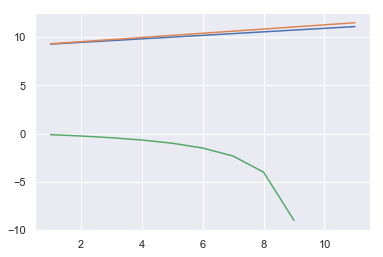

In [22]:
x = np.arange(1, 12)
sns.lineplot(x, AICs)
sns.lineplot(x, BICs)
sns.lineplot(x, adj_r2s)

BKSS also selects the model with $X^3$ the only feature.

## e. Lasso

In [23]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

alphas = np.array([10**i for i in np.linspace(-3, 0, num=20)])
lassos = {'alpha': alphas, '5_fold_cv_error': []}

In [24]:
for alpha in alphas:
        lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1e8, tol=1e-2)
        cv_error = np.mean(- cross_val_score(lasso, X, y, cv=5, 
                                             scoring='neg_mean_squared_error'))
        lassos['5_fold_cv_error'] += [cv_error]

In [25]:
lassos_df = pd.DataFrame(lassos)
lassos_df

,alpha,5_fold_cv_error
0,0.001000,0.836428
1,0.001438,0.819378
2,0.002069,0.895901
3,0.002976,0.893177
4,0.004281,0.888498
5,0.006158,0.885597
6,0.008859,0.884861
7,0.012743,0.884489
8,0.018330,0.888298
9,0.026367,0.894860


In [26]:
(alpha_hat, cv_error_min) = lassos_df.iloc[lassos_df['5_fold_cv_error'].idxmin(), ]
(alpha_hat, cv_error_min)

(0.0014384498882876629, 0.8193781004864231)

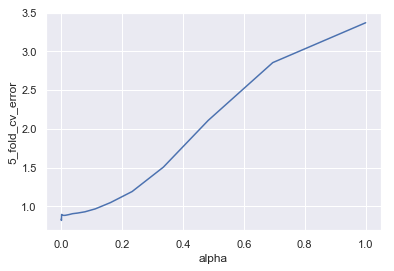

In [27]:
sns.lineplot(x='alpha', y='5_fold_cv_error', data=lassos_df)

Now we'll see what coefficient estimates this model produces

In [28]:
np.set_printoptions(suppress=True)
lasso_model = Lasso(alpha=alpha_hat, fit_intercept=False, max_iter=1e8, tol=1e-2).fit(X, y)
lasso_model.coef_

array([ 1.06544938,  0.80612409,  2.05979396,  0.7883535 , -1.66945357,
        0.24562823,  0.76952192, -0.0535788 , -0.13390294,  0.0027605 ,
        0.00767839])

In [29]:
model_df = pd.DataFrame({'coef_': lasso_model.coef_}, index=data.columns[:-1])
model_df.sort_values(by='coef_', ascending=False)

,coef_
X^2,2.059794
X^0,1.065449
X^1,0.806124
X^3,0.788354
X^6,0.769522
X^5,0.245628
X^10,0.007678
X^9,0.002760
X^7,-0.053579
X^8,-0.133903


Let's check this model on a validation set:

In [30]:
data_valid = pd.DataFrame({'X_valid^' + str(i): X_valid**i for i in range(11)})
data_valid['y_valid'] = y_valid
data_valid.head()

,X_valid^0,X_valid^1,X_valid^2,X_valid^3,X_valid^4,X_valid^5,X_valid^6,X_valid^7,X_valid^8,X_valid^9,X_valid^10,y_valid
0,1.0,1.315735,1.731159,2.277747,2.996911,3.943142,5.188130,6.826205,8.981478,11.817247,15.548367,7.109116
1,1.0,0.754402,0.569123,0.429348,0.323901,0.244352,0.184340,0.139066,0.104912,0.079146,0.059708,3.052666
2,1.0,0.910262,0.828578,0.754223,0.686541,0.624932,0.568852,0.517805,0.471338,0.429041,0.390540,3.389726
3,1.0,-0.528947,0.279785,-0.147991,0.078279,-0.041406,0.021901,-0.011585,0.006128,-0.003241,0.001714,2.010106
4,1.0,-1.271336,1.616296,-2.054856,2.612413,-3.321256,4.222433,-5.368133,6.824703,-8.676493,11.030740,-1.018760


In [31]:
y_pred = lasso_model.predict(data_valid.drop(columns=['y_valid']))
errors = y_pred - y_valid
lasso_mse_test = np.mean(np.dot(errors, errors))
lasso_mse_test

90.33155498089704

In [32]:
model_selection_df = model_selection_df.append(pd.DataFrame({'mse_test': [lasso_mse_test]}, index=['lasso']))
model_selection_df

,mse_test
bss,642.701423
lasso,90.331555


A considerable improvement over the BSS model

## f. Repeat for a new response

We now repeat the above for a model

$$Y = \beta_0 + \beta_7 X^t + \epsilon$$

### New response

In [106]:
# new train/test response
y = np.array(100*[1]) + data['X^7'] + e

# new validation response
y_valid = np.array(100*[1]) + data_valid['X_valid^7'] + e

# update dfs
data.loc[:, 'y'], data_valid.loc[:, 'y_valid'] = y, y_valid

### BSS model

In [87]:
bss = {}

for k in range(1, 12):
    reg = LinearRegression()
    efs = EFS(reg, 
               min_features=k,
               max_features=k,
               scoring='neg_mean_squared_error',
               print_progress=False,
               cv=None)
    efs = efs.fit(data.drop(columns=['y']), data['y'])
    bss[k] = efs.best_idx_

bss

{1: (7,),
 2: (7, 9),
 3: (1, 3, 7),
 4: (1, 5, 7, 10),
 5: (1, 7, 8, 9, 10),
 6: (1, 4, 6, 7, 8, 9),
 7: (2, 4, 6, 7, 8, 9, 10),
 8: (1, 2, 4, 5, 6, 7, 8, 10),
 9: (2, 3, 4, 5, 6, 7, 8, 9, 10),
 10: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
 11: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)}

In [88]:
X, y = data.drop(columns=['y']).values, data['y'].values
mses = mse_estimates(X, y, bss)
mses

/Users/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


{1: {'AIC': 9.272727272727272,
  'BIC': 9.308899570254397,
  'adj_r2': -0.11111111111111116},
 2: {'AIC': 9.454545454545455, 'BIC': 9.526890049599706, 'adj_r2': -0.25},
 3: {'AIC': 9.636363636363637,
  'BIC': 9.74488052894501,
  'adj_r2': -0.4285714285714286},
 4: {'AIC': 9.818181818181817,
  'BIC': 9.962871008290316,
  'adj_r2': -0.6666666666666667},
 5: {'AIC': 10.000000000000002, 'BIC': 10.180861487635623, 'adj_r2': -1.0},
 6: {'AIC': 10.18181818181818, 'BIC': 10.398851966980928, 'adj_r2': -1.5},
 7: {'AIC': 10.363636363636365,
  'BIC': 10.616842446326238,
  'adj_r2': -2.3333333333333335},
 8: {'AIC': 10.545454545454547, 'BIC': 10.834832925671542, 'adj_r2': -4.0},
 9: {'AIC': 10.727272727272723, 'BIC': 11.052823405016845, 'adj_r2': -9.0},
 10: {'AIC': 10.909090909090908, 'BIC': 11.270813884362154, 'adj_r2': -inf},
 11: {'AIC': 11.090909090909088, 'BIC': 11.488804363707459, 'adj_r2': 11.0}}

In [89]:
AICs = np.array([mses[k]['AIC'] for k in mses])
BICs = np.array([mses[k]['BIC'] for k in mses])
adj_r2s = np.array([mses[k]['adj_r2'] for k in mses])

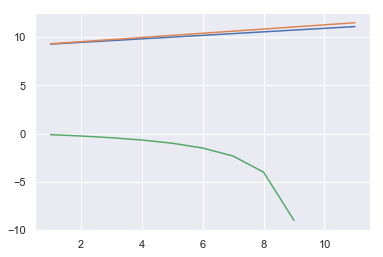

In [90]:
x = np.arange(1, 12)
sns.lineplot(x, AICs)
sns.lineplot(x, BICs)
sns.lineplot(x, adj_r2s)

Again, BSS likes a single predictor (this time $X^{10}$)

In [91]:
bss_model = LinearRegression().fit(data['X^7'].values.reshape(-1,1), data['y'].values)
bss_model.coef_

array([0.99897181])

Now, lets generate a validataion data set and check this model's mse

In [92]:
y_pred = bss_model.coef_ * X_valid**3
errors = y_pred - y_valid
bss_mse_test = np.mean(np.dot(errors, errors))
bss_mse_test

91636.16819263707

In [93]:
model_selection_df = pd.DataFrame({'mse_test': [bss_mse_test]}, index=['bss'])
model_selection_df

,mse_test
bss,91636.168193


### Lasso model

In [94]:
alphas = np.array([10**i for i in np.linspace(-4, 1, num=50)])
lassos = {'alpha': alphas, '5_fold_cv_error': []}

for alpha in alphas:
        lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1e6, tol=1e-3)
        cv_error = np.mean(- cross_val_score(lasso, X, y, cv=5, 
                                             scoring='neg_mean_squared_error'))
        lassos['5_fold_cv_error'] += [cv_error]

In [95]:
(alpha, cv_error_min) = lassos_df.iloc[lassos_df['5_fold_cv_error'].idxmin(), ]
(alpha, cv_error_min)

(0.028117686979742307, 2.750654968384496)

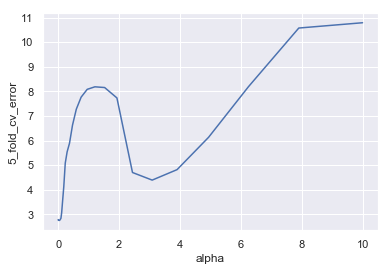

In [96]:
lassos_df = pd.DataFrame(lassos)
sns.lineplot(x='alpha', y='5_fold_cv_error', data=lassos_df)

Now we'll see what coefficient estimates this model produces

In [97]:
lasso_model = Lasso(alpha=alpha, fit_intercept=False, max_iter=1e8, tol=1e-2).fit(X, y)
lasso_model.coef_

array([-0.        ,  1.43769581,  4.23293404, -4.72479707, -1.3268075 ,
        2.69250184, -0.02715976,  0.40441206,  0.01230247,  0.04725243,
        0.00255472])

In [98]:
model_df = pd.DataFrame({'coef_': lasso_model.coef_}, index=data.columns[:-1])
model_df.sort_values(by='coef_', ascending=False)

,coef_
X^2,4.232934
X^5,2.692502
X^1,1.437696
X^7,0.404412
X^9,0.047252
X^8,0.012302
X^10,0.002555
X^0,-0.000000
X^6,-0.027160
X^4,-1.326808


In [110]:
y_pred = lasso_model.predict(data_valid.drop(columns=['y_valid']))
errors = y_pred - y_valid
lasso_mse_test = np.mean(np.dot(errors, errors))
lasso_mse_test

292.261615448788

In [111]:
model_selection_df = model_selection_df.append(pd.DataFrame({'mse_test': [lasso_mse_test]}, index=['lasso']))
model_selection_df

,mse_test
bss,91636.168193
lasso,292.261615


Once again, the lasso dramatically outperforms.